<h1 style="background-color:#EBF5FB; color:#2471A3;">Intro</h1>

In this notebook, I am modeling breast cancer tumor types using deep learning. I use a feedforward neural network designed for binary classification, consisting of three fully connected layers with ReLU activations and a sigmoid activation function at the output layer to predict the probability of a binary outcome.
The dataset is based on can be found at https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset/code.

<h1 style="background-color:#EBF5FB; color:#2471A3 ;">Understanding the problem statment</h1>

<p>Breast cancer is one of the most common cancers among women worldwide. Early detection and diagnosis are crucial for improving the survival rate and reducing the mortality associated with the disease. The goal of this analysis is to leverage deep learning techniques to classify tumors as benign or malignant based on various features derived from medical images.</p>
<p>The dataset used in this analysis consists of tumor measurements, including:

- **Radius**: The mean of distances from the center to points on the perimeter.
- **Texture**: The standard deviation of gray-scale values.
- **Smoothness**: The local variation in radius lengths.
- **Compactness**: The perimeter squared divided by the area minus 1.0.
- **Concavity**: The severity of concave portions of the contour.
- **Concave Points**: The number of concave portions of the contour.
- **Symmetry**: The symmetry of the tumor.
- **Fractal Dimension**: A measure of the complexity of the contour.

These features are used to predict the target variable, which indicates whether the tumor is benign (non-cancerous) or malignant (cancerous). The dataset includes labeled data, which allows us to train supervised learning models.

The primary objectives of this analysis are:

1. **Data Exploration and Preprocessing**: Understand the distribution of features, handle missing values, and normalize the data to prepare it for model training.
2. **Model Building**: Construct and train deep learning models to accurately classify the tumors.
3. **Model Evaluation**: Assess the performance of the models using appropriate metrics such as accuracy, precision, recall, and F1-score.
4. **Interpretability**: Understand the important features contributing to the model's predictions to provide insights into the diagnosis process.

By accomplishing these objectives, I aim to build a robust model that can assist medical professionals in the early detection and diagnosis of breast cancer, ultimately improving patient outcomes.</p>

<h1 style="background-color:#EBF5FB; color:#2471A3;">Library imports</h1>

In [408]:
# Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Statistical Analysis
import scipy.stats as stats
from scipy.stats import shapiro, kstest
from scipy.stats import skew, kurtosis

# Utility Libraries
import itertools

# Deep Learning with PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset
import torchmetrics

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE

# Machine Learning with Scikit-learn
import sklearn
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, f1_score, accuracy_score

<h1 style="background-color:#EBF5FB; color:#2471A3;">Getting to know the dataset</h1>

- Exploring dataset features and their data types.
- Cleaning of duplicates, missing values and uninformative features.
- Performing initial exploration of data distribution normality of the dataset.

In [409]:
# Loading the dataset
df = pd.read_csv('/Users/dominika/Documents/Coding_learning/Project.DL_heart_attack_prediction/breast-cancer.csv')

In [410]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

<p style="background-color:#FDEBD0;"><b>CHECK POINT:</b> 32 features in total, each contains 569 data points.The dataset features consist of 10 distinct tumor measurement categories, each measured in three variations: mean, standard error (se), and worst.</p>

In [411]:
#  Show the full dataset
pd.set_option('display.max_columns', None)
df.sample(10)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
119,865128,M,17.95,20.01,114.20,982.0,0.08402,0.06722,0.072930,0.055960,0.2129,0.05025,0.5506,1.2140,3.357,54.04,0.004024,0.008422,0.022910,0.009863,0.05014,0.001902,20.580,27.83,129.20,1261.0,0.10720,0.12020,0.224900,0.11850,0.4882,0.06111
192,875099,B,9.72,18.22,60.73,288.1,0.06950,0.02344,0.000000,0.000000,0.1653,0.06447,0.3539,4.8850,2.230,21.69,0.001713,0.006736,0.000000,0.000000,0.03799,0.001688,9.968,20.83,62.25,303.8,0.07117,0.02729,0.000000,0.00000,0.1909,0.06559
368,9011971,M,21.71,17.25,140.90,1546.0,0.09384,0.08562,0.116800,0.084650,0.1717,0.05054,1.2070,1.0510,7.733,224.10,0.005568,0.011120,0.020960,0.011970,0.01263,0.001803,30.750,26.44,199.50,3143.0,0.13630,0.16280,0.286100,0.18200,0.2510,0.06494
69,859487,B,12.78,16.49,81.37,502.5,0.09831,0.05234,0.036530,0.028640,0.1590,0.05653,0.2368,0.8732,1.471,18.33,0.007962,0.005612,0.015850,0.008662,0.02254,0.001906,13.460,19.76,85.67,554.9,0.12960,0.07061,0.103900,0.05882,0.2383,0.06410
149,869931,B,13.74,17.91,88.12,585.0,0.07944,0.06376,0.028810,0.013290,0.1473,0.05580,0.2500,0.7574,1.573,21.47,0.002838,0.015920,0.017800,0.005828,0.01329,0.001976,15.340,22.46,97.19,725.9,0.09711,0.18240,0.156400,0.06019,0.2350,0.07014
450,9111596,B,11.87,21.54,76.83,432.0,0.06613,0.10640,0.087770,0.023860,0.1349,0.06612,0.2560,1.5540,1.955,20.24,0.006854,0.060630,0.066630,0.015530,0.02354,0.008925,12.790,28.18,83.51,507.2,0.09457,0.33990,0.321800,0.08750,0.2305,0.09952
436,908916,B,12.87,19.54,82.67,509.2,0.09136,0.07883,0.017970,0.020900,0.1861,0.06347,0.3665,0.7693,2.597,26.50,0.005910,0.013620,0.007066,0.006502,0.02223,0.002378,14.450,24.38,95.14,626.9,0.12140,0.16520,0.071270,0.06384,0.3313,0.07735
246,884448,B,13.20,17.43,84.13,541.6,0.07215,0.04524,0.043360,0.011050,0.1487,0.05635,0.1630,1.6010,0.873,13.56,0.006261,0.015690,0.030790,0.005383,0.01962,0.002250,13.940,27.82,88.28,602.0,0.11010,0.15080,0.229800,0.04970,0.2767,0.07198
366,9011494,M,20.20,26.83,133.70,1234.0,0.09905,0.16690,0.164100,0.126500,0.1875,0.06020,0.9761,1.8920,7.128,103.60,0.008439,0.046740,0.059040,0.025360,0.03710,0.004286,24.190,33.81,160.00,1671.0,0.12780,0.34160,0.370300,0.21520,0.3271,0.07632
276,8911230,B,11.33,14.16,71.79,396.6,0.09379,0.03872,0.001487,0.003333,0.1954,0.05821,0.2375,1.2800,1.565,17.09,0.008426,0.008998,0.001487,0.003333,0.02358,0.001627,12.200,18.99,77.37,458.0,0.12590,0.07348,0.004955,0.01111,0.2758,0.06386


In [412]:
# Drop uninformative features
df.drop(['id'], axis=1, inplace=True)

In [413]:
df.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [414]:
df['diagnosis'].unique()

array(['M', 'B'], dtype=object)

In [415]:
# Recode categorical variables: 'diagnosis'
df['diagnosis'] = df['diagnosis'].apply(lambda x: 0 if x=='B' else 1)


In [416]:
df.sample(10)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
166,0,10.80,9.71,68.77,357.6,0.09594,0.05736,0.02531,0.01698,0.1381,0.06400,0.1728,0.4064,1.126,11.48,0.007809,0.009816,0.01099,0.005344,0.01254,0.002120,11.60,12.02,73.66,414.0,0.1436,0.1257,0.1047,0.04603,0.2090,0.07699
154,0,13.15,15.34,85.31,538.9,0.09384,0.08498,0.09293,0.03483,0.1822,0.06207,0.2710,0.7927,1.819,22.79,0.008584,0.020170,0.03047,0.009536,0.02769,0.003479,14.77,20.50,97.67,677.3,0.1478,0.2256,0.3009,0.09722,0.3849,0.08633
283,1,16.24,18.77,108.80,805.1,0.10660,0.18020,0.19480,0.09052,0.1876,0.06684,0.2873,0.9173,2.464,28.09,0.004563,0.034810,0.03872,0.012090,0.01388,0.004081,18.55,25.09,126.90,1031.0,0.1365,0.4706,0.5026,0.17320,0.2770,0.10630
338,0,10.05,17.53,64.41,310.8,0.10070,0.07326,0.02511,0.01775,0.1890,0.06331,0.2619,2.0150,1.778,16.85,0.007803,0.014490,0.01690,0.008043,0.02100,0.002778,11.16,26.84,71.98,384.0,0.1402,0.1402,0.1055,0.06499,0.2894,0.07664
164,1,23.27,22.04,152.10,1686.0,0.08439,0.11450,0.13240,0.09702,0.1801,0.05553,0.6642,0.8561,4.603,97.85,0.004910,0.025440,0.02822,0.016230,0.01956,0.003740,28.01,28.22,184.20,2403.0,0.1228,0.3583,0.3948,0.23460,0.3589,0.09187
383,0,12.39,17.48,80.64,462.9,0.10420,0.12970,0.05892,0.02880,0.1779,0.06588,0.2608,0.8730,2.117,19.20,0.006715,0.037050,0.04757,0.010510,0.01838,0.006884,14.18,23.13,95.23,600.5,0.1427,0.3593,0.3206,0.09804,0.2819,0.11180
385,1,14.60,23.29,93.97,664.7,0.08682,0.06636,0.08390,0.05271,0.1627,0.05416,0.4157,1.6270,2.914,33.01,0.008312,0.017420,0.03389,0.015760,0.01740,0.002871,15.79,31.71,102.20,758.2,0.1312,0.1581,0.2675,0.13590,0.2477,0.06836
483,0,13.70,17.64,87.76,571.1,0.09950,0.07957,0.04548,0.03160,0.1732,0.06088,0.2431,0.9462,1.564,20.64,0.003245,0.008186,0.01698,0.009233,0.01285,0.001524,14.96,23.53,95.78,686.5,0.1199,0.1346,0.1742,0.09077,0.2518,0.06960
220,0,13.65,13.16,87.88,568.9,0.09646,0.08711,0.03888,0.02563,0.1360,0.06344,0.2102,0.4336,1.391,17.40,0.004133,0.016950,0.01652,0.006659,0.01371,0.002735,15.34,16.35,99.71,706.2,0.1311,0.2474,0.1759,0.08056,0.2380,0.08718
204,0,12.47,18.60,81.09,481.9,0.09965,0.10580,0.08005,0.03821,0.1925,0.06373,0.3961,1.0440,2.497,30.29,0.006953,0.019110,0.02701,0.010370,0.01782,0.003586,14.97,24.64,96.05,677.9,0.1426,0.2378,0.2671,0.10150,0.3014,0.08750


In [417]:
# Check for duplicates
df.duplicated().sum()

np.int64(0)

In [418]:
# Check for missing data
df.isnull().sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

<p style="background-color:#FDEBD0;"><b>CHECK POINT:</b> The dataset is free from duplicates and missing values, so no additional handling is required before modeling.</p>

In [419]:
# Check for imbalance of the target feature
benign = df[df['diagnosis'] == 0].size
malignant = df[df['diagnosis'] == 1].size
percent = round(malignant * 100 / (malignant + benign), 2)
print(f'Benign: {benign}, Malignant: {malignant}')
print(f'The percentage of patients with a malignant tumor: {percent}%')

Benign: 11067, Malignant: 6572
The percentage of patients with a malignant tumor: 37.26%


<p style="background-color:#FDEBD0;"><b>CHECK POINT:</b> The dataset exhibits a moderate class imbalance with 37.26% of tumors being malignant, which is not extreme but may require consideration to ensure balanced model performance.</p>

array([[<Axes: title={'center': 'diagnosis'}>,
        <Axes: title={'center': 'radius_mean'}>,
        <Axes: title={'center': 'texture_mean'}>,
        <Axes: title={'center': 'perimeter_mean'}>,
        <Axes: title={'center': 'area_mean'}>,
        <Axes: title={'center': 'smoothness_mean'}>],
       [<Axes: title={'center': 'compactness_mean'}>,
        <Axes: title={'center': 'concavity_mean'}>,
        <Axes: title={'center': 'concave points_mean'}>,
        <Axes: title={'center': 'symmetry_mean'}>,
        <Axes: title={'center': 'fractal_dimension_mean'}>,
        <Axes: title={'center': 'radius_se'}>],
       [<Axes: title={'center': 'texture_se'}>,
        <Axes: title={'center': 'perimeter_se'}>,
        <Axes: title={'center': 'area_se'}>,
        <Axes: title={'center': 'smoothness_se'}>,
        <Axes: title={'center': 'compactness_se'}>,
        <Axes: title={'center': 'concavity_se'}>],
       [<Axes: title={'center': 'concave points_se'}>,
        <Axes: title={'cent

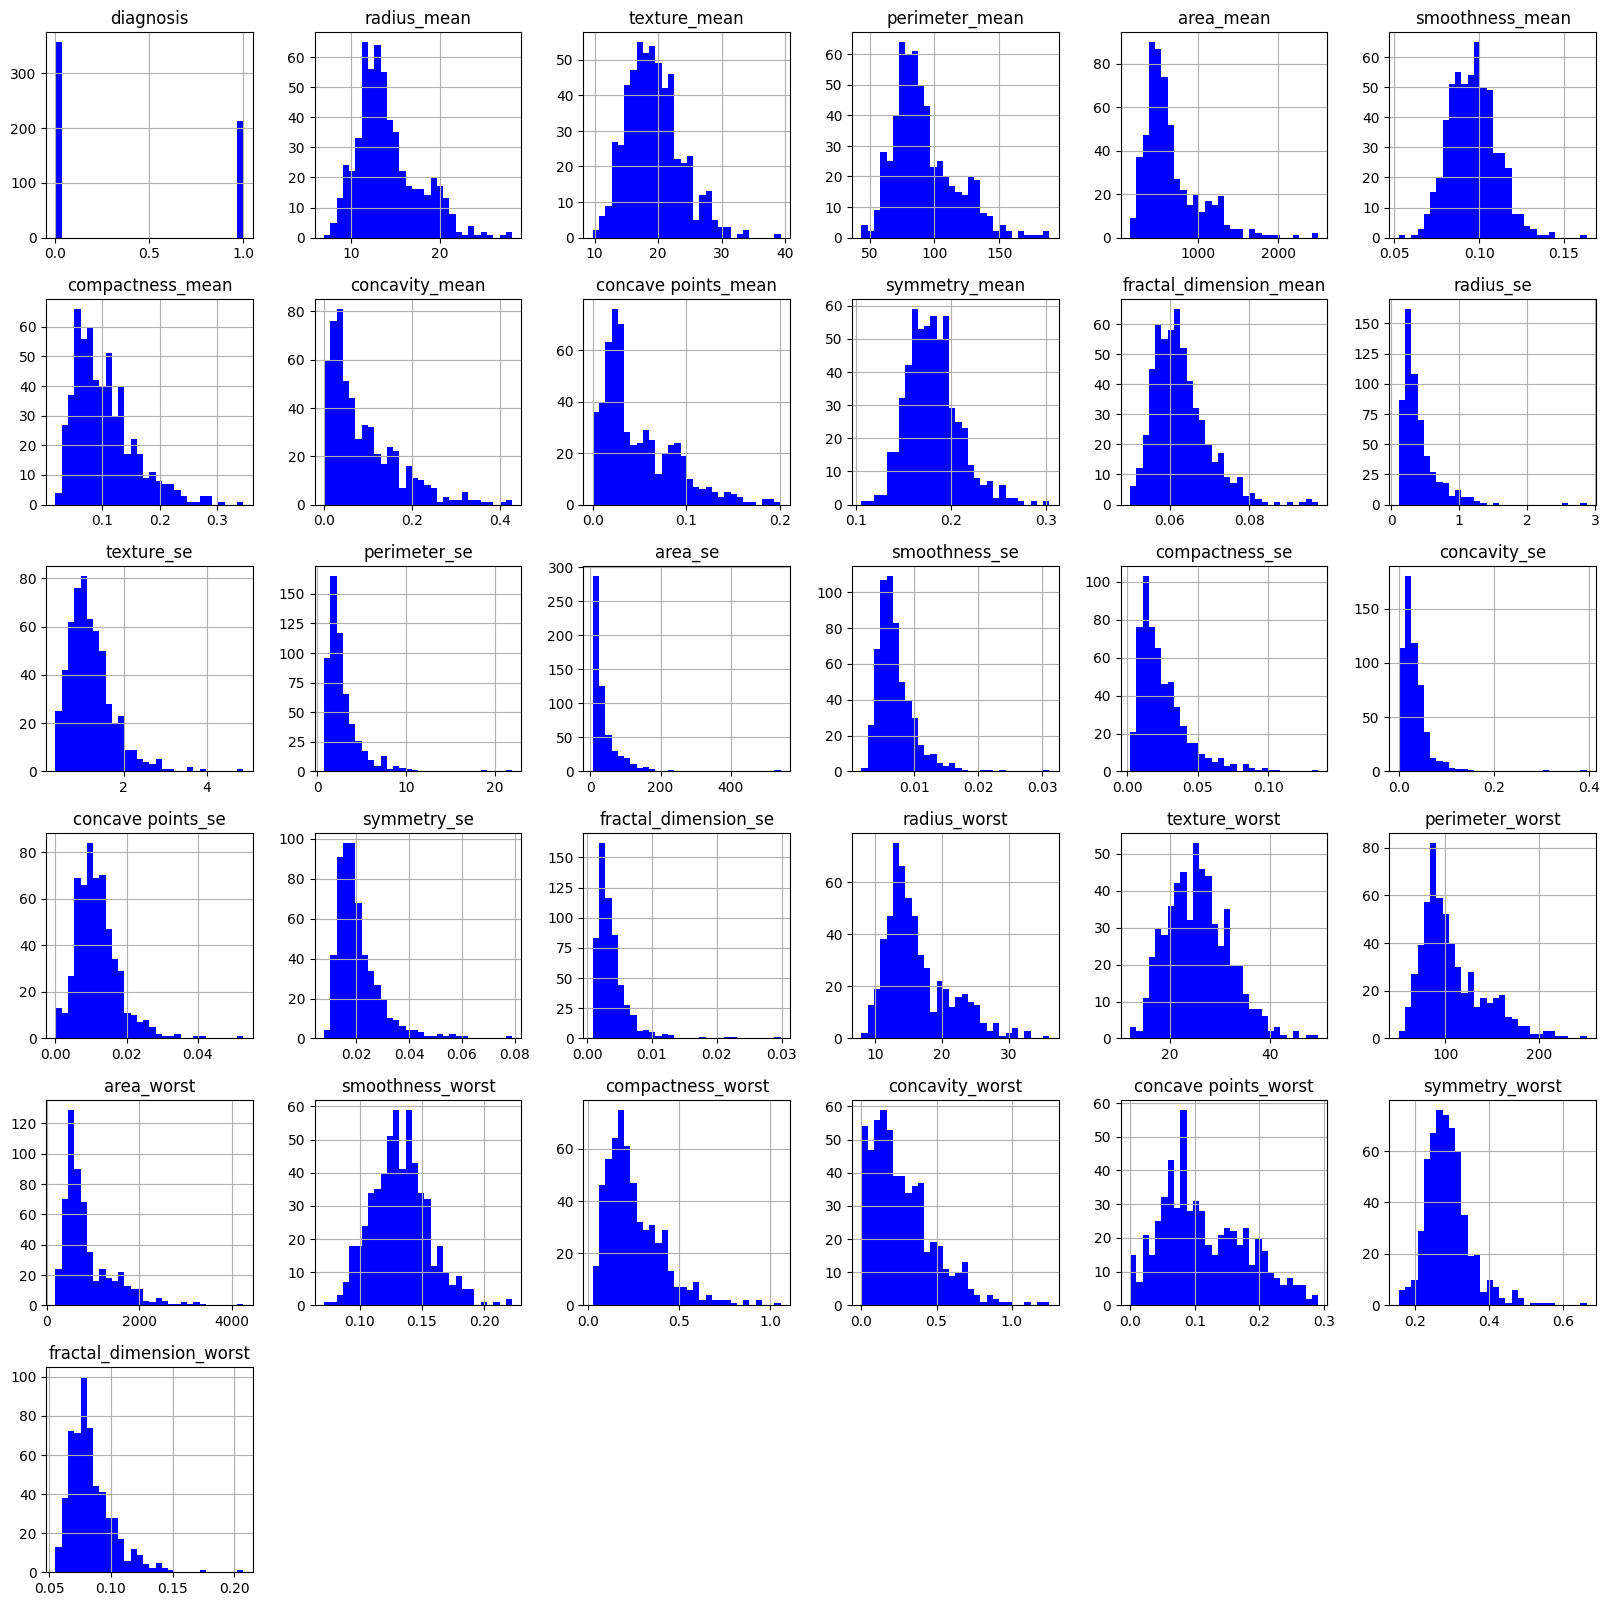

In [420]:
# Explore the distribution of the individual features 
df.hist(bins=30, figsize=(20,20), color='b')

In [421]:
# General descriptive stats function
def get_full_descriptives(df):
    descriptive_stats = df.describe()
    skewness = df.apply(skew)
    kurt = df.apply(kurtosis)
    descriptive_stats.loc['skewness'] = skewness
    descriptive_stats.loc['kurtosis'] = kurt
    return descriptive_stats.round(1)

In [422]:
# Print general descriptive stats
get_full_descriptives(df)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0
mean,0.4,14.1,19.3,92.0,654.9,0.1,0.1,0.1,0.0,0.2,0.1,0.4,1.2,2.9,40.3,0.0,0.0,0.0,0.0,0.0,0.0,16.3,25.7,107.3,880.6,0.1,0.3,0.3,0.1,0.3,0.1
std,0.5,3.5,4.3,24.3,351.9,0.0,0.1,0.1,0.0,0.0,0.0,0.3,0.6,2.0,45.5,0.0,0.0,0.0,0.0,0.0,0.0,4.8,6.1,33.6,569.4,0.0,0.2,0.2,0.1,0.1,0.0
min,0.0,7.0,9.7,43.8,143.5,0.1,0.0,0.0,0.0,0.1,0.0,0.1,0.4,0.8,6.8,0.0,0.0,0.0,0.0,0.0,0.0,7.9,12.0,50.4,185.2,0.1,0.0,0.0,0.0,0.2,0.1
25%,0.0,11.7,16.2,75.2,420.3,0.1,0.1,0.0,0.0,0.2,0.1,0.2,0.8,1.6,17.8,0.0,0.0,0.0,0.0,0.0,0.0,13.0,21.1,84.1,515.3,0.1,0.1,0.1,0.1,0.3,0.1
50%,0.0,13.4,18.8,86.2,551.1,0.1,0.1,0.1,0.0,0.2,0.1,0.3,1.1,2.3,24.5,0.0,0.0,0.0,0.0,0.0,0.0,15.0,25.4,97.7,686.5,0.1,0.2,0.2,0.1,0.3,0.1
75%,1.0,15.8,21.8,104.1,782.7,0.1,0.1,0.1,0.1,0.2,0.1,0.5,1.5,3.4,45.2,0.0,0.0,0.0,0.0,0.0,0.0,18.8,29.7,125.4,1084.0,0.1,0.3,0.4,0.2,0.3,0.1
max,1.0,28.1,39.3,188.5,2501.0,0.2,0.3,0.4,0.2,0.3,0.1,2.9,4.9,22.0,542.2,0.0,0.1,0.4,0.1,0.1,0.0,36.0,49.5,251.2,4254.0,0.2,1.1,1.3,0.3,0.7,0.2
skewness,0.5,0.9,0.6,1.0,1.6,0.5,1.2,1.4,1.2,0.7,1.3,3.1,1.6,3.4,5.4,2.3,1.9,5.1,1.4,2.2,3.9,1.1,0.5,1.1,1.9,0.4,1.5,1.1,0.5,1.4,1.7
kurtosis,-1.7,0.8,0.7,1.0,3.6,0.8,1.6,2.0,1.0,1.3,3.0,17.5,5.3,21.2,48.8,10.4,5.1,48.4,5.1,7.8,26.0,0.9,0.2,1.1,4.3,0.5,3.0,1.6,-0.5,4.4,5.2


<p style="background-color:#FDEBD0;"><b>CHECK POINT: </b>The dataset largely deviates from a normal distribution, potentially requiring data transformation techniques to improve model performance and accuracy.</p>

<h1 style="background-color:#EBF5FB; color:#2471A3;">EDA</h1>

EDA lays the foundation for understanding how dataset features are interrelated, which is crucial for two main reasons:
- Model Selection: It helps in selecting an appropriate model by ensuring that the data adheres to the assumptions of the chosen model, thereby enhancing model accuracy.
- Relationship Exploration: It provides an initial comprehension of the relationships between features and between features and the target variable, aiding in the formulation of hypotheses and guiding subsequent analysis steps.

<h3 style="background-color:#EBF5FB; color:#2471A3;">Exploring data normality by Tumor Type</h3>
<p style="color:#2471A3;">Assessing the normality of the distributions of the independent factors by tumor type ('benign' vs. 'malignant'). This is done to eluminate how these factors vary between tumor types, aiding in the identification of potential influential trends.</p>

In [423]:
# SPlit the dataset by tumor type
benign = df[df['diagnosis'] == 0]
malignant = df[df['diagnosis'] == 1]

In [424]:
# Show descriptive statistics for tthe benign group
print('The "BENIGN" group:')
get_full_descriptives(benign)

The "BENIGN" group:


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,357.0,357.0,357.0,357.0,357.0,357.0,357.0,357.0,357.0,357.0,357.0,357.0,357.0,357.0,357.0,357.0,357.0,357.0,357.0,357.0,357.0,357.0,357.0,357.0,357.0,357.0,357.0,357.0,357.0,357.0,357.0
mean,0.0,12.1,17.9,78.1,462.8,0.1,0.1,0.0,0.0,0.2,0.1,0.3,1.2,2.0,21.1,0.0,0.0,0.0,0.0,0.0,0.0,13.4,23.5,87.0,558.9,0.1,0.2,0.2,0.1,0.3,0.1
std,0.0,1.8,4.0,11.8,134.3,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.6,0.8,8.8,0.0,0.0,0.0,0.0,0.0,0.0,2.0,5.5,13.5,163.6,0.0,0.1,0.1,0.0,0.0,0.0
min,0.0,7.0,9.7,43.8,143.5,0.1,0.0,0.0,0.0,0.1,0.1,0.1,0.4,0.8,6.8,0.0,0.0,0.0,0.0,0.0,0.0,7.9,12.0,50.4,185.2,0.1,0.0,0.0,0.0,0.2,0.1
25%,0.0,11.1,15.2,70.9,378.2,0.1,0.1,0.0,0.0,0.2,0.1,0.2,0.8,1.4,15.3,0.0,0.0,0.0,0.0,0.0,0.0,12.1,19.6,78.3,447.1,0.1,0.1,0.1,0.1,0.2,0.1
50%,0.0,12.2,17.4,78.2,458.4,0.1,0.1,0.0,0.0,0.2,0.1,0.3,1.1,1.9,19.6,0.0,0.0,0.0,0.0,0.0,0.0,13.4,22.8,86.9,547.4,0.1,0.2,0.1,0.1,0.3,0.1
75%,0.0,13.4,19.8,86.1,551.1,0.1,0.1,0.1,0.0,0.2,0.1,0.3,1.5,2.4,25.0,0.0,0.0,0.0,0.0,0.0,0.0,14.8,26.5,96.6,670.0,0.1,0.2,0.2,0.1,0.3,0.1
max,0.0,17.8,33.8,114.6,992.1,0.2,0.2,0.4,0.1,0.3,0.1,0.9,4.9,5.1,77.1,0.0,0.1,0.4,0.1,0.1,0.0,19.8,41.8,127.1,1210.0,0.2,0.6,1.3,0.2,0.4,0.1
skewness,NaN,-0.1,1.0,-0.1,0.3,0.7,1.2,3.5,0.9,0.7,1.6,1.5,1.6,1.2,1.6,1.5,2.2,6.3,2.1,1.4,4.3,-0.0,0.7,0.0,0.4,0.3,1.1,2.5,0.1,0.2,1.4
kurtosis,NaN,-0.0,1.2,-0.0,0.3,1.8,2.2,20.5,1.0,1.3,4.4,3.9,5.3,1.7,5.3,3.0,5.9,58.2,10.5,3.3,27.3,-0.2,0.4,-0.2,0.2,0.4,1.7,12.4,-0.2,0.3,3.1


In [425]:
# Show descriptive statistics for tthe malignant group
print('THE MALIGNANT GROUP:')
get_full_descriptives(malignant)

THE MALIGNANT GROUP:


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/apply.py:1081: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.func(v, *self.args, **self.kwargs)


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,212.0,212.0,212.0,212.0,212.0,212.0,212.0,212.0,212.0,212.0,212.0,212.0,212.0,212.0,212.0,212.0,212.0,212.0,212.0,212.0,212.0,212.0,212.0,212.0,212.0,212.0,212.0,212.0,212.0,212.0,212.0
mean,1.0,17.5,21.6,115.4,978.4,0.1,0.1,0.2,0.1,0.2,0.1,0.6,1.2,4.3,72.7,0.0,0.0,0.0,0.0,0.0,0.0,21.1,29.3,141.4,1422.3,0.1,0.4,0.5,0.2,0.3,0.1
std,0.0,3.2,3.8,21.9,367.9,0.0,0.1,0.1,0.0,0.0,0.0,0.3,0.5,2.6,61.4,0.0,0.0,0.0,0.0,0.0,0.0,4.3,5.4,29.5,598.0,0.0,0.2,0.2,0.0,0.1,0.0
min,1.0,11.0,10.4,71.9,361.6,0.1,0.0,0.0,0.0,0.1,0.0,0.2,0.4,1.3,14.0,0.0,0.0,0.0,0.0,0.0,0.0,12.8,16.7,85.1,508.1,0.1,0.1,0.0,0.0,0.2,0.1
25%,1.0,15.1,19.3,98.7,705.3,0.1,0.1,0.1,0.1,0.2,0.1,0.4,0.9,2.7,35.8,0.0,0.0,0.0,0.0,0.0,0.0,17.7,25.8,119.3,970.3,0.1,0.2,0.3,0.2,0.3,0.1
50%,1.0,17.3,21.5,114.2,932.0,0.1,0.1,0.2,0.1,0.2,0.1,0.5,1.1,3.7,58.5,0.0,0.0,0.0,0.0,0.0,0.0,20.6,28.9,138.0,1303.0,0.1,0.4,0.4,0.2,0.3,0.1
75%,1.0,19.6,23.8,129.9,1203.8,0.1,0.2,0.2,0.1,0.2,0.1,0.8,1.4,5.2,94.0,0.0,0.0,0.1,0.0,0.0,0.0,23.8,32.7,159.8,1712.8,0.2,0.4,0.6,0.2,0.4,0.1
max,1.0,28.1,39.3,188.5,2501.0,0.1,0.3,0.4,0.2,0.3,0.1,2.9,3.6,22.0,542.2,0.0,0.1,0.1,0.0,0.1,0.0,36.0,49.5,251.2,4254.0,0.2,1.1,1.2,0.3,0.7,0.2
skewness,NaN,0.5,0.7,0.6,1.1,0.5,0.8,0.9,0.7,0.8,0.9,2.5,1.5,2.8,4.3,3.9,1.8,1.6,1.4,2.5,1.7,0.6,0.5,0.7,1.3,0.4,1.1,0.9,-0.1,1.1,1.4
kurtosis,NaN,0.3,2.3,0.5,2.2,0.4,0.8,1.1,0.7,1.3,1.3,11.8,3.8,13.6,28.3,27.0,5.5,3.6,3.6,7.9,3.9,0.3,1.1,0.6,2.6,0.8,1.6,1.4,0.1,2.4,3.8


In [426]:
# Normality stats function by target feature
def shapiro_test_per_group(malignant, benign):
    normality_results = {}
    columns = malignant.columns
    for column in columns:
        malignant_stat, malignant_p = shapiro(malignant[column])
        benign_stat, benign_p = shapiro(benign[column])
        normality_results[column] = {
            'Statistic (malignant)': malignant_stat, 
            'p-value (malignant)': malignant_p, 
            'Normality (malignant)': malignant_p > 0.05,
            'Statistic (benign)': benign_stat, 
            'p-value (benign)': benign_p, 
            'Normality (benign)': benign_p > 0.05
        }

    return pd.DataFrame(normality_results).T

In [427]:
# Show normality stats of the features by target feature levels
shapiro_test_per_group(malignant, benign)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


,Statistic (malignant),p-value (malignant),Normality (malignant),Statistic (benign),p-value (benign),Normality (benign)
diagnosis,1.0,1.0,True,1.0,1.0,True
radius_mean,0.97766,0.001895,False,0.996653,0.667993,True
texture_mean,0.969095,0.000134,False,0.944173,0.0,False
perimeter_mean,0.973015,0.000433,False,0.997096,0.779494,True
area_mean,0.933262,0.0,False,0.990641,0.022778,False
smoothness_mean,0.984686,0.021498,False,0.975511,0.00001,False
compactness_mean,0.957435,0.000006,False,0.925871,0.0,False
concavity_mean,0.952931,0.000002,False,0.737276,0.0,False
concave points_mean,0.961331,0.000016,False,0.946724,0.0,False
symmetry_mean,0.964875,0.000041,False,0.974092,0.000005,False


<p style="background-color:#FDEBD0;"><b>CHECK POINT: </b>The data for each tumor type is also non-normally distributed. Again, transformation or normalization techniques may be needed.</p>

<h3 style="background-color:#EBF5FB; color:#2471A3;">Exploring relationships between features</h3>

<p style="color:#2471A3;">Conducting correlation analysis among the dataset features to unveil potential linear associations, thereby facilitating a comprehensive exploration of interrelationships within the dataset.</p>

In [428]:
# Run Pearson correlation between dataset features
correlation_matrix = df.corr(method='pearson')

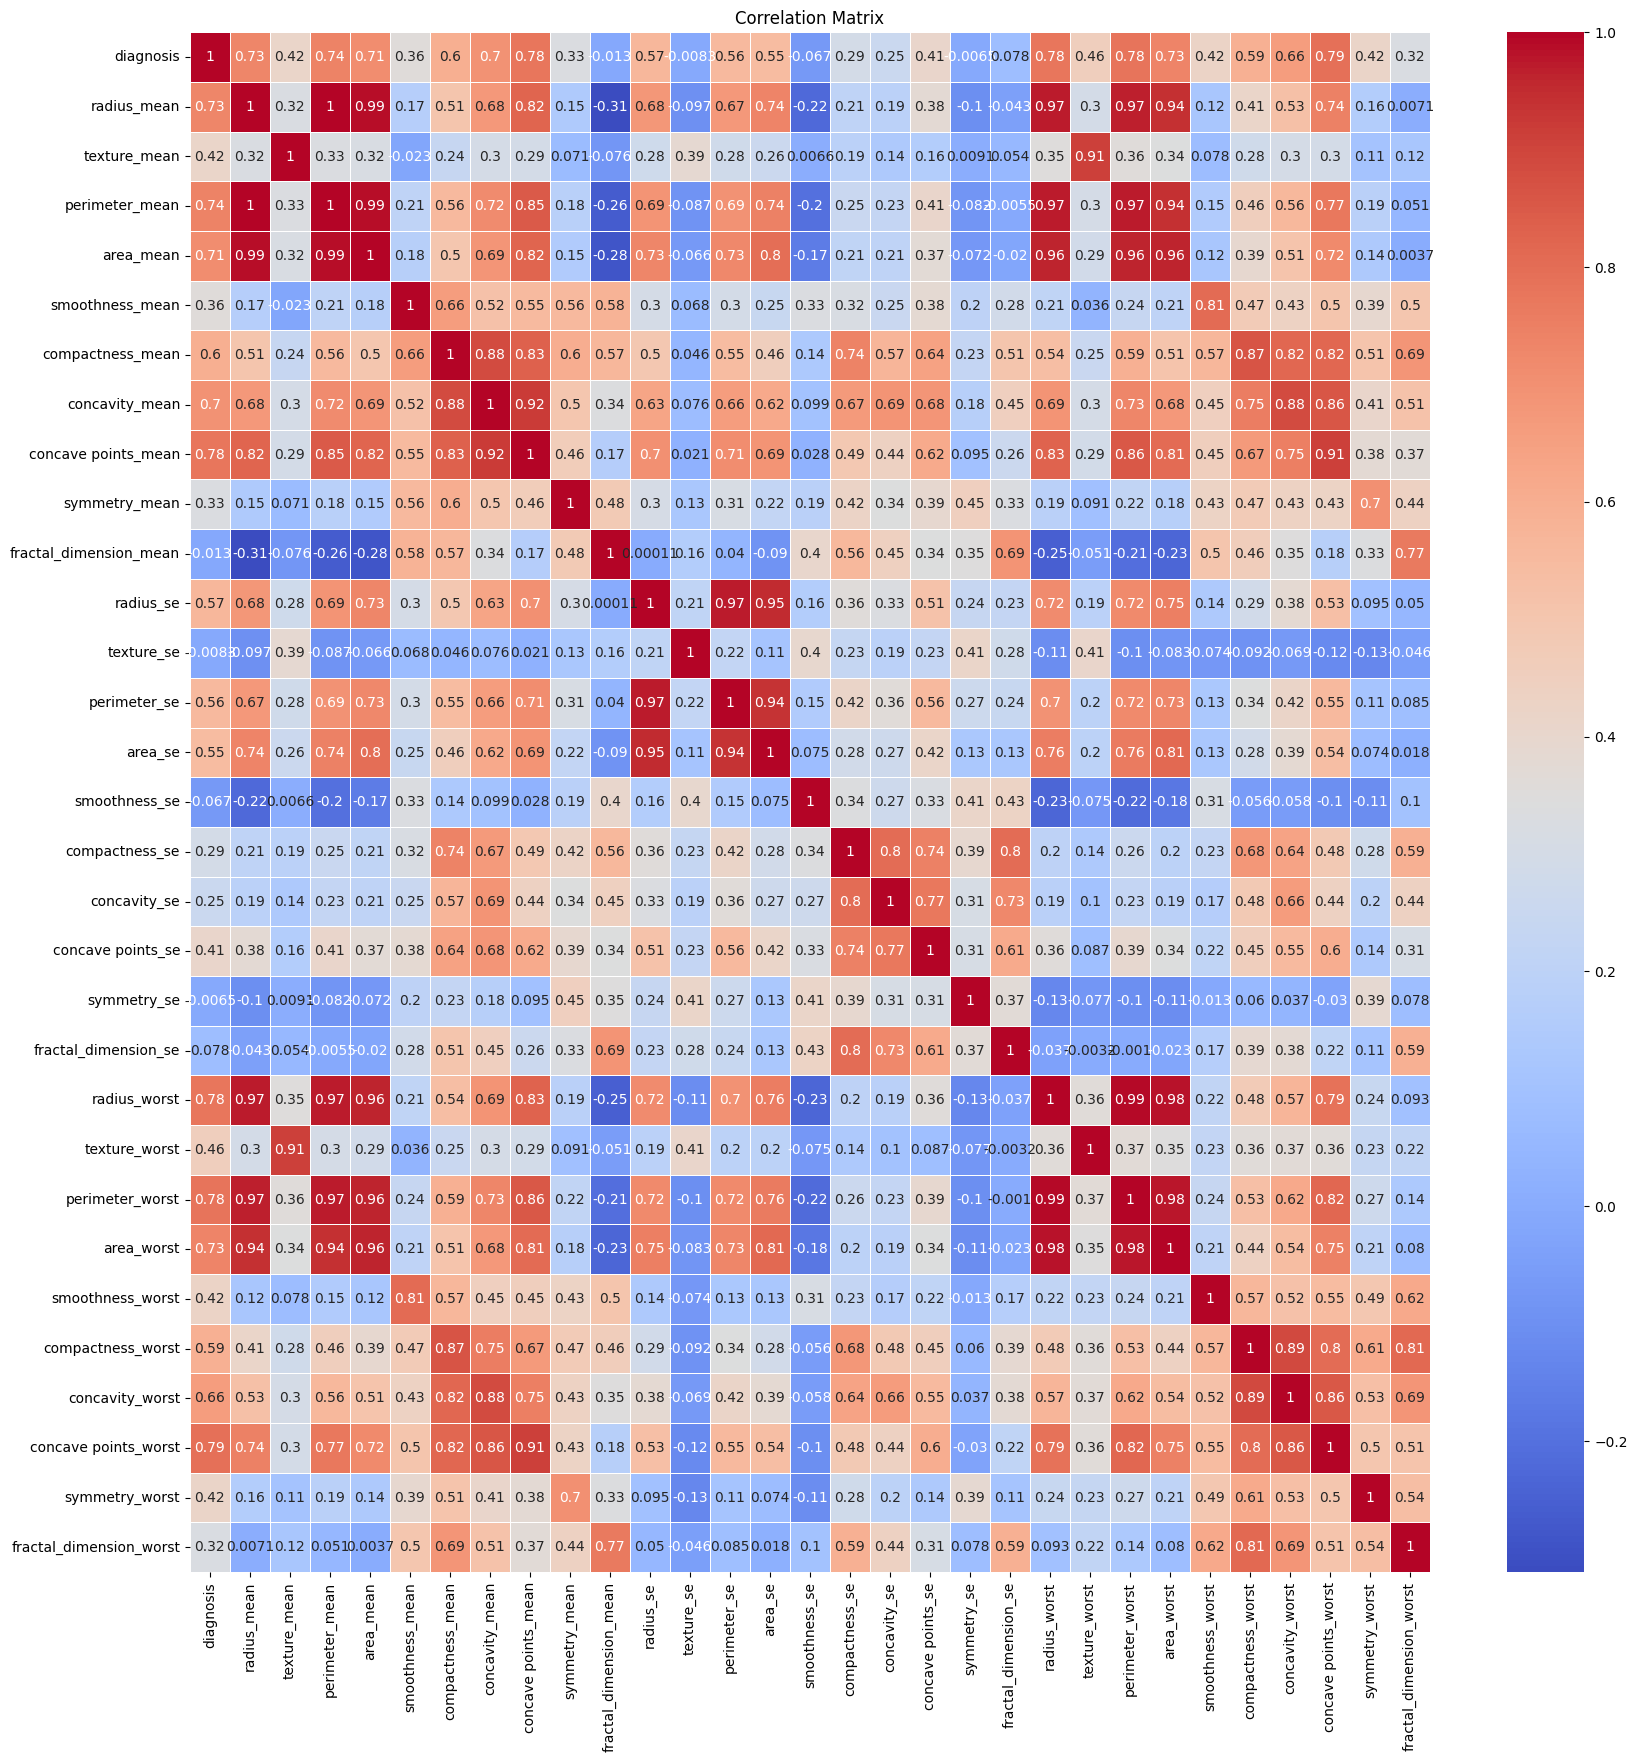

In [429]:
# Plot the correlation coefficients
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm',linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

<p style="background-color:#FDEBD0;"><b>CHECK POINT: </b>There is high collinearity between features. This was expected given the fact that the features correspond to 10 distinct tumor measurement categories, each with 3 potentially related  measurement descriptives: mean, standard error (se), and worst.</p>
<p style="background-color:#FDEBD0;">A dimensionality reduction technique such as PCA (Principal Component Analysis) is necessary to prevent redundant information from degrading the model performance</p>

<h1 style="background-color:#EBF5FB; color:#2471A3;">Feature engineering</h1>

In [430]:
# Separate features and labels
X = df.drop(columns=['diagnosis'])
y = df['diagnosis']

In [431]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

<p style="background-color:#FDEBD0;"><b>CHECK POINT: </b>Scaling was performed to ensure that all input variables contribute equally to the model's performance, prevent features with larger numerical ranges from dominating the learning process, and improve the convergence speed and stability of optimization algorithms used in training the model.</p>

In [432]:
# Perform PCA
pca = PCA(n_components=0.95, random_state=20)  # Retain 95% of variance
X_pca = pca.fit_transform(X_scaled)

# Convert PCA components to a DataFrame
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

# Add the diagnosis column to the PCA DataFrame for reference
pca_df['diagnosis'] = y.reset_index(drop=True)

# Display the explained variance by each principal component
explained_variance = pca.explained_variance_ratio_
print(f'Explained variance by each principal component: {explained_variance}')

# Display the first few rows of the PCA DataFrame
pca_df.sample(10)

Explained variance by each principal component: [0.44272026 0.18971182 0.09393163 0.06602135 0.05495768 0.04024522
 0.02250734 0.01588724 0.01389649 0.01168978]


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,diagnosis
52,-3.450489,-0.498219,-0.152518,-0.575486,0.052315,0.629891,0.060827,0.511323,0.413987,0.823773,0
312,-2.136404,-0.004393,-0.055139,-1.788113,-1.300445,-0.063118,0.414767,0.299979,-0.072581,-0.072514,0
204,-0.781190,0.652849,-0.643657,-0.214468,0.437680,-0.160489,0.187235,-0.068190,0.533758,0.189562,0
333,-4.386423,-0.761104,-0.400597,-0.586857,0.376579,0.535766,0.732746,-0.070654,-0.001498,0.304929,0
516,2.697224,-1.943710,-0.960564,-0.459509,0.584498,-0.491726,-0.517209,-0.050073,-0.131473,0.226077,1
186,0.364876,-3.574461,-2.223979,-0.223168,-0.778531,0.510230,-0.562793,0.235439,-0.325622,0.124681,1
54,-0.674619,-2.116410,-1.396220,1.043139,-0.241817,-0.656655,-0.215453,0.207698,0.505783,0.108597,1
277,0.017431,-3.459343,0.306921,-0.475570,-0.400737,-0.156907,-1.874215,0.780082,-0.352233,0.159203,1
352,10.934298,-3.703254,-0.891694,-2.343508,0.488786,0.196436,-0.109741,0.219842,-1.763028,-0.462273,1
499,5.094842,-2.019208,-0.709370,0.082795,-0.383817,-1.447936,-0.573494,-0.650120,-0.536048,0.251212,1


In [433]:
# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance)
print(cumulative_explained_variance)

[0.44272026 0.63243208 0.72636371 0.79238506 0.84734274 0.88758796
 0.9100953  0.92598254 0.93987903 0.95156881]


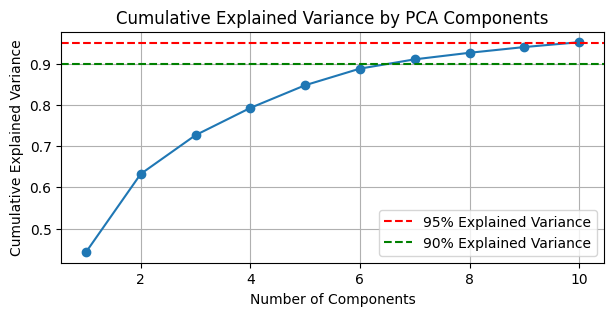

In [434]:
# Plot the cumulative explained variance
plt.figure(figsize=(7, 3))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.axhline(y=0.90, color='g', linestyle='--', label='90% Explained Variance')
plt.legend(loc='best')
plt.show()

In [435]:
X = pca_df.drop(columns = ['diagnosis'], axis=1)

<p style="background-color:#FDEBD0;"><b>CHECK POINT: </b>To retain maximum information, I will use all 10 components, which account for 95% of the variance in the original dataset, in building the NN model.</p>

<h1 style="background-color:#EBF5FB; color:#2471A3;">Model building</h1>

<h3 style="background-color:#EBF5FB; color:#2471A3;">Model specification</h3>

In [436]:
# Define a binary classification model
class BinaryClassificationModel(nn.Module):
    def __init__(self, num_features):
        super(BinaryClassificationModel, self).__init__()
        self.fc1 = nn.Linear(num_features, 8) 
        self.fc2 = nn.Linear(8, 4)
        self.fc3 = nn.Linear(4, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [437]:
# Early Stopping function
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [438]:
# Training function

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, patience=5):
    early_stopping = EarlyStopping(patience=patience)
    # Lists to keep track of metrics
    training_losses = []
    validation_losses = []
    training_accuracies = []
    validation_accuracies = []

    for epoch in range(num_epochs):
        model.train()  # Training mode
        training_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            training_loss += loss.item()

            # Calculate accuracy
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels.unsqueeze(1)).sum().item()
            total += labels.size(0)

        training_loss /= len(train_loader)
        training_accuracy = 100 * correct / total
        training_losses.append(training_loss)
        training_accuracies.append(training_accuracy)

        # Validation phase
        model.eval()  # Evaluation mode
        validation_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels.unsqueeze(1))
                validation_loss += loss.item()

                # Calculate accuracy
                predicted = (outputs > 0.5).float()
                correct += (predicted == labels.unsqueeze(1)).sum().item()
                total += labels.size(0)

        validation_loss /= len(val_loader)
        validation_accuracy = 100 * correct / total
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {training_loss:.4f}, Training Accuracy: {training_accuracy:.2f}%, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%")
        
        early_stopping(validation_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Load the best model
    model.load_state_dict(torch.load('checkpoint.pt'))
    
    return training_losses, validation_losses, training_accuracies, validation_accuracies

<p style="background-color:#FDEBD0;"><b>CHECK POINT: </b>The model  employs a straightforward feedforward neural network architecture with three fully connected layers, using an appropriate number of neurons (8, 4, and 1) to balance model complexity and performance, effectively capturing non-linear relationships in the data, while the final sigmoid activation ensures appropriate output probabilities for binary classification. Additionally, early stopping is implemented to prevent overfitting and improve generalization.</p>

<h3 style="background-color:#EBF5FB; color:#2471A3;">Dataset preparation and split</h3>

In [439]:
# Set a random seed for reproducibility
random_seed = 20
torch.manual_seed(random_seed)

# Convert data to torch tensor format
features = torch.tensor(X.to_numpy()).float()
target = torch.tensor(y.to_numpy()).float() 

# Create a dataset from the tensors
dataset = TensorDataset(features, target)

# Split the dataset into train, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size],
                                                        generator=torch.Generator().manual_seed(random_seed))

<h3 style="background-color:#EBF5FB; color:#2471A3;">Training</h3>

In [440]:
# Create DataLoader for each dataset
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [441]:
# Initialize the model
model = BinaryClassificationModel(num_features=features.shape[1])

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [442]:
# Train the model
training_losses, validation_losses, training_accuracies, validation_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=25, patience=5)

Epoch 1/25, Training Loss: 0.6287, Training Accuracy: 67.91%, Validation Loss: 0.6333, Validation Accuracy: 66.07%
Epoch 2/25, Training Loss: 0.6221, Training Accuracy: 71.21%, Validation Loss: 0.6222, Validation Accuracy: 69.64%
Epoch 3/25, Training Loss: 0.6014, Training Accuracy: 76.04%, Validation Loss: 0.6103, Validation Accuracy: 71.43%
Epoch 4/25, Training Loss: 0.5905, Training Accuracy: 80.44%, Validation Loss: 0.5984, Validation Accuracy: 75.00%
Epoch 5/25, Training Loss: 0.5895, Training Accuracy: 84.18%, Validation Loss: 0.5859, Validation Accuracy: 82.14%
Epoch 6/25, Training Loss: 0.5662, Training Accuracy: 87.03%, Validation Loss: 0.5721, Validation Accuracy: 87.50%
Epoch 7/25, Training Loss: 0.5614, Training Accuracy: 89.01%, Validation Loss: 0.5569, Validation Accuracy: 87.50%
Epoch 8/25, Training Loss: 0.5427, Training Accuracy: 92.09%, Validation Loss: 0.5415, Validation Accuracy: 89.29%
Epoch 9/25, Training Loss: 0.5227, Training Accuracy: 93.85%, Validation Loss: 0

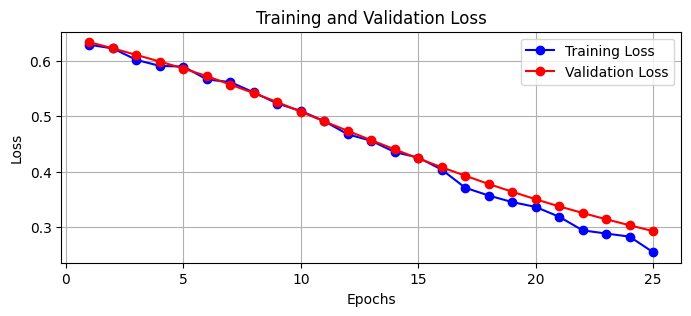

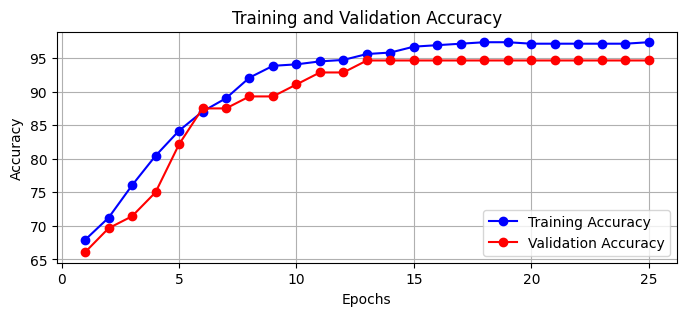

In [443]:
epochs = range(1, len(training_losses) + 1)

# Plot training and validation loss
plt.figure(figsize=(8, 3))
plt.plot(epochs, training_losses, 'bo-', label='Training Loss')
plt.plot(epochs, validation_losses, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(8, 3))
plt.plot(epochs, training_accuracies, 'bo-', label='Training Accuracy')
plt.plot(epochs, validation_accuracies, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

<p style="background-color:#FDEBD0;"><b>CHECK POINT: </b>The model shows a strong performance with steady improvements in both training and validation metrics over 25 epochs. Starting with a training accuracy of 67.91% and validation accuracy of 66.07%, it progresses to 97.36% and 94.64% respectively by the final epoch. Both training and validation loss consistently decrease, with training loss dropping from 0.6287 to 0.2545 and validation loss from 0.6333 to 0.2925. Despite slight differences between training and validation accuracy, the close alignment and stable performance suggest effective learning and good generalization, though minor overfitting may still be present, leaving room for further tuning and potential improvement.</p>

<h1 style="background-color:#EBF5FB; color:#2471A3;">Hyperparameter tuning</h1>

In [444]:
# Define the hyperparameter grid
batch_sizes = [32, 64]
learning_rates = [0.001, 0.01, 0.1]
num_epochs_list = [25, 50]

# Create a grid of hyperparameters
hyperparameter_grid = list(itertools.product(batch_sizes, learning_rates, num_epochs_list))

In [445]:
# Track the best parameters and the best validation accuracy
best_params = None
best_val_accuracy = -np.inf


for batch_size, learning_rate, num_epochs in hyperparameter_grid:
    print(f"Training with batch_size={batch_size}, learning_rate={learning_rate}, num_epochs={num_epochs}")
    
    # Create DataLoader for each dataset
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize the model
    model = BinaryClassificationModel(num_features=features.shape[1])

    # Define loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    training_losses, validation_losses, training_accuracies, validation_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=5)

    # Get the best validation accuracy for this hyperparameter set
    best_epoch_val_accuracy = max(validation_accuracies)

    # Check if this is the best validation accuracy so far
    if best_epoch_val_accuracy > best_val_accuracy:
        best_val_accuracy = best_epoch_val_accuracy
        best_params = (batch_size, learning_rate, num_epochs)

# Print the best hyperparameters
print(f"Best hyperparameters: batch_size={best_params[0]}, learning_rate={best_params[1]}, num_epochs={best_params[2]}")
print(f"Best validation accuracy: {best_val_accuracy:.4f}")

Training with batch_size=32, learning_rate=0.001, num_epochs=25
Epoch 1/25, Training Loss: 0.8116, Training Accuracy: 36.92%, Validation Loss: 0.7761, Validation Accuracy: 42.86%
Epoch 2/25, Training Loss: 0.7958, Training Accuracy: 36.92%, Validation Loss: 0.7652, Validation Accuracy: 42.86%
Epoch 3/25, Training Loss: 0.7836, Training Accuracy: 36.92%, Validation Loss: 0.7556, Validation Accuracy: 42.86%
Epoch 4/25, Training Loss: 0.7725, Training Accuracy: 36.92%, Validation Loss: 0.7467, Validation Accuracy: 42.86%
Epoch 5/25, Training Loss: 0.7702, Training Accuracy: 36.92%, Validation Loss: 0.7374, Validation Accuracy: 42.86%
Epoch 6/25, Training Loss: 0.7568, Training Accuracy: 36.92%, Validation Loss: 0.7276, Validation Accuracy: 42.86%
Epoch 7/25, Training Loss: 0.7389, Training Accuracy: 36.92%, Validation Loss: 0.7167, Validation Accuracy: 42.86%
Epoch 8/25, Training Loss: 0.7335, Training Accuracy: 36.92%, Validation Loss: 0.7041, Validation Accuracy: 42.86%
Epoch 9/25, Trai

<p style="background-color:#FDEBD0;"><b>CHECK POINT: </b>After hyperparameter tuning with various combinations of learning rates, batch sizes, and number of epochs, the model's optimal performance was achieved with a batch size of 32, a learning rate of 0.01, and 25 epochs. This configuration resulted in a best validation accuracy of 98.21%. The training process showed significant improvements across iterations, with early stopping mechanisms in place to prevent overfitting. The slight decrease in accuracy towards the end is not uncommon and indicates an area for potential improvement but does not significantly detract from the model's effectiveness. Regular monitoring and possibly refining the training process can help in maintaining high performance consistently.</p>

<h1 style="background-color:#EBF5FB; color:#2471A3;">Final model training and evaluation on the test set</h1>

In [446]:
# Combine train and validation datasets for final training
combined_train_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])
combined_train_loader = DataLoader(combined_train_dataset, batch_size=32, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=32)

In [447]:
# Training function without early stopping and validation step
def train_model(model, train_loader, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        model.train()
        training_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            training_loss += loss.item()

            predicted = (outputs > 0.5).float()
            correct += (predicted == labels.unsqueeze(1)).sum().item()
            total += labels.size(0)

        training_loss /= len(train_loader)
        training_accuracy = 100 * correct / total

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {training_loss:.4f}, Training Accuracy: {training_accuracy:.2f}%")


In [448]:
# Initialize the model, loss function, and optimizer with the best hyperparameters
model = BinaryClassificationModel(num_features=features.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model on the combined training set
train_model(model, combined_train_loader, criterion, optimizer, num_epochs=25)

Epoch 1/25, Training Loss: 0.6991, Training Accuracy: 45.99%
Epoch 2/25, Training Loss: 0.6287, Training Accuracy: 80.23%
Epoch 3/25, Training Loss: 0.3908, Training Accuracy: 93.93%
Epoch 4/25, Training Loss: 0.1312, Training Accuracy: 96.87%
Epoch 5/25, Training Loss: 0.0686, Training Accuracy: 98.24%
Epoch 6/25, Training Loss: 0.0590, Training Accuracy: 98.24%
Epoch 7/25, Training Loss: 0.0517, Training Accuracy: 98.83%
Epoch 8/25, Training Loss: 0.0517, Training Accuracy: 98.63%
Epoch 9/25, Training Loss: 0.0453, Training Accuracy: 98.63%
Epoch 10/25, Training Loss: 0.0451, Training Accuracy: 98.83%
Epoch 11/25, Training Loss: 0.0399, Training Accuracy: 98.63%
Epoch 12/25, Training Loss: 0.0405, Training Accuracy: 99.02%
Epoch 13/25, Training Loss: 0.0344, Training Accuracy: 99.02%
Epoch 14/25, Training Loss: 0.0329, Training Accuracy: 99.02%
Epoch 15/25, Training Loss: 0.0315, Training Accuracy: 99.02%
Epoch 16/25, Training Loss: 0.0320, Training Accuracy: 99.02%
Epoch 17/25, Trai

In [449]:
# Evaluation function
def evaluate_model(model, data_loader, criterion):
    model.eval()
    eval_loss = 0.0
    metric = torchmetrics.Accuracy(num_classes=1, average='macro', threshold=0.5, task='binary')
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            eval_loss += loss.item()
            preds = (outputs > 0.5).float()
            all_labels.extend(labels.tolist())
            all_preds.extend(preds.squeeze(1).tolist())
            metric.update(preds, labels.unsqueeze(1))

    eval_loss /= len(data_loader)
    accuracy = metric.compute().item()
    print(f"Loss: {eval_loss:.4f}, Accuracy: {accuracy:.4f}")
    return all_labels, all_preds

In [450]:
# Evaluate the model on the test set
all_labels, all_preds = evaluate_model(model, test_loader, criterion)

Loss: 0.0455, Accuracy: 0.9828


------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99        38
         1.0       1.00      0.95      0.97        20

    accuracy                           0.98        58
   macro avg       0.99      0.97      0.98        58
weighted avg       0.98      0.98      0.98        58

------------------------------------------------------------------------------------------


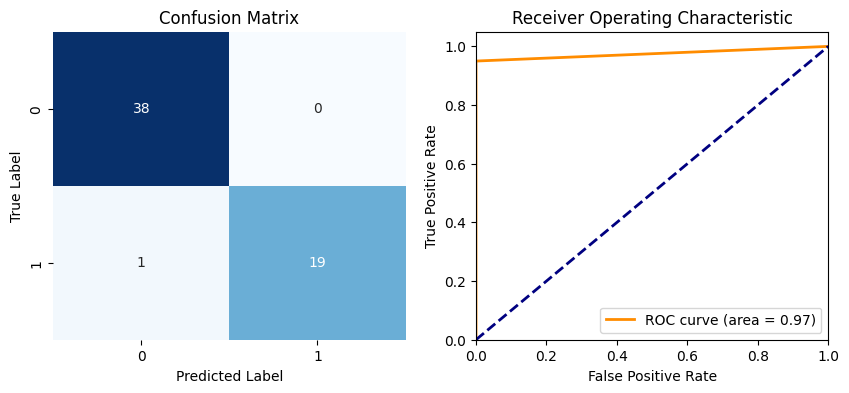

In [451]:
# Print the classification report
print('---'*30)
print(classification_report(all_labels, all_preds))
print('---'*30)

# Calculate the confusion matrix and ROC curve
cm = confusion_matrix(all_labels, all_preds)
fpr, tpr, _ = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

# Plot the confusion matrix and ROC curve 
fig, axs = plt.subplots(1, 2, figsize=(10, 4))  

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axs[0])
axs[0].set_title('Confusion Matrix')
axs[0].set_xlabel('Predicted Label')
axs[0].set_ylabel('True Label')

axs[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
axs[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[1].set_xlim([0.0, 1.0])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('Receiver Operating Characteristic')
axs[1].legend(loc='lower right')

plt.show()

<p style="background-color:#FDEBD0;"><b>FINAL MODEL EVALUATION:</b> For the final model evaluation, the validation and training sets were combined, and the model was retrained. The retraining process showed consistent improvement in both training accuracy and loss, culminating in a final training accuracy of 99.61%.</p>
<p style="background-color:#FDEBD0;"> The evaluation on the test set showed an accuracy of 98%. However, given the target feature imbalance, the F1 score is a more indicative measure of overall model performance. The F1 score was 0.99 for benign and 0.97 for malignant tumors, indicating the model's robustness in handling both classes. The ROC curve with an area of 0.97 demonstrates excellent discriminative ability between the two classes.</p>
<p style="background-color:#FDEBD0;"> Overall, the model's performance remains robust, indicating that it is effective and generalizes well to new data. However, there is potential room for improvement, as the model misclassified one malignant tumor as benign, while correctly classifying all benign tumors. Achieving 100% accuracy in distinguishing malignant tumors is the desired performance, and to achieve this, handling class imbalance or introducing dropout layers to the network might help.</p>